In [149]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler , StandardScaler , RobustScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator
from scipy.stats import boxcox, zscore
from warnings import filterwarnings
filterwarnings("ignore")
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [150]:
# Importing Data
INPUT_PATH = "E:/Programming/MLMomeni/ML/files/state.xlsx"
df = pd.read_excel(INPUT_PATH)
df.columns = df.columns.map(lambda x: x.strip() if isinstance(x, str) else x)
df.head()

,Row Labels,Sum of sales,Sum of Profit,Sum of Discount
0,Alabama,1.184244e+05,5786.8253,0.0
1,Arizona,1.700034e+05,-3427.9246,68.0
2,Arkansas,4.989575e+04,4008.6871,0.0
3,California,2.301218e+06,76381.3871,145.6
4,Colorado,1.455911e+05,-6527.8579,57.6


In [151]:
# Required Features for Clustering
FEATURES = ["Sum of sales", "Sum of Profit", 'Sum of Discount']

In [152]:
#Finding the best K value function
def choose_best_k(X):
    List = []
    kmeans_set = {'init': 'random', 'n_init':300, 'random_state':42}
    for k in range(1, 11):
        scaler = StandardScaler()
        scaled_features = scaler.fit_transform(X)
        kmeans = KMeans(n_clusters=k, **kmeans_set)
        kmeans.fit(scaled_features)
        List.append(kmeans.inertia_)
    k1 = KneeLocator(range(1, 11), List, curve='convex', direction='decreasing')
    best_k = k1.elbow
    plt.plot(range(1, 11), List)
    plt.xticks(range(1, 11))
    plt.xlabel('clusters')
    plt.ylabel('inertia')
    plt.axvline(x=k1.elbow, color='b', label='axvline', ls='--')
    plt.show()
    return best_k

In [153]:
# Model Function
def kmeans_cluster(dfx, features):
    kmeans_set = {'init': 'random', 'n_init':300, 'random_state':42}
    X = dfx[features].astype(float).values
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)
    k = choose_best_k(Xs)
    km = KMeans(n_clusters=k, **kmeans_set)
    labels = km.fit_predict(Xs)
    dfx["Cluster"] = labels
    #Plot
    cluster_colors = {0: '#1f77b4',# Blue
                      1: '#ff7f0e',# Orange
                      2: '#2ca02c',# Green
                      3: '#d62728',# Red
                      4: '80080'}#Purple
    colors = dfx["Cluster"].map(cluster_colors)
    fig = plt.figure(figsize=(13, 13))
    ax = fig.add_subplot(projection='3d')
    scatter = ax.scatter(dfx["Sum of sales"], dfx["Sum of Profit"],dfx['Sum of Discount'],c=colors,marker='o')
    ax.set_xlabel("Sum of sales")
    ax.set_ylabel("Sum of Profit")
    ax.set_zlabel('Sum of Discount')
    ax.set_title('3D Scatter Plot Of Customer data by cluster')
    plt.show()
    return labels, k
    

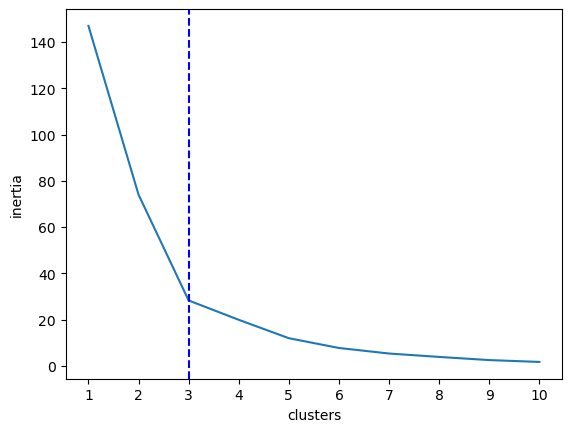

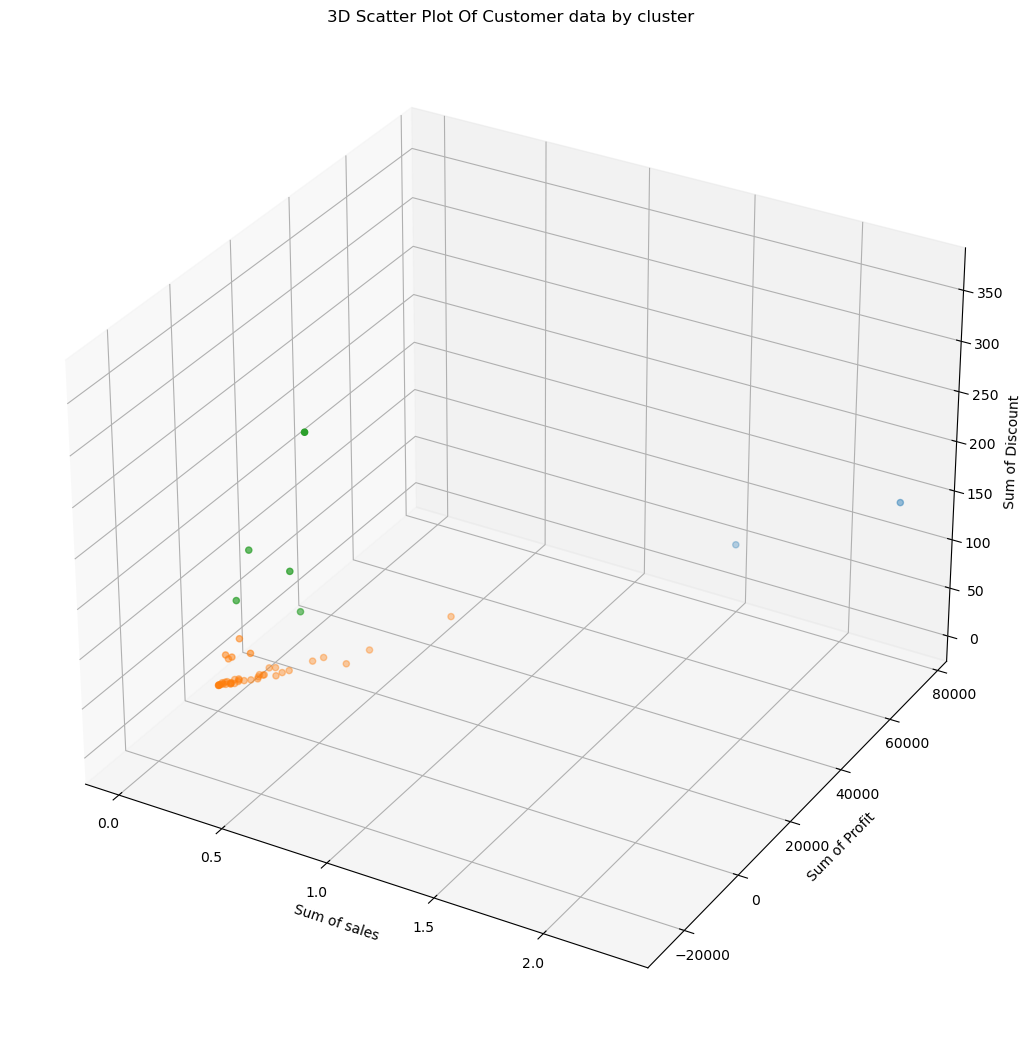

Best k = 3 | rows = 49


In [154]:
# Clustering
full_df = df.dropna(subset=[c for c in FEATURES if c in df.columns]).copy()
full_labels, full_k = kmeans_cluster(full_df, FEATURES)
print("Best k =", full_k, "| rows =", len(full_df))

<Figure size 1200x600 with 0 Axes>

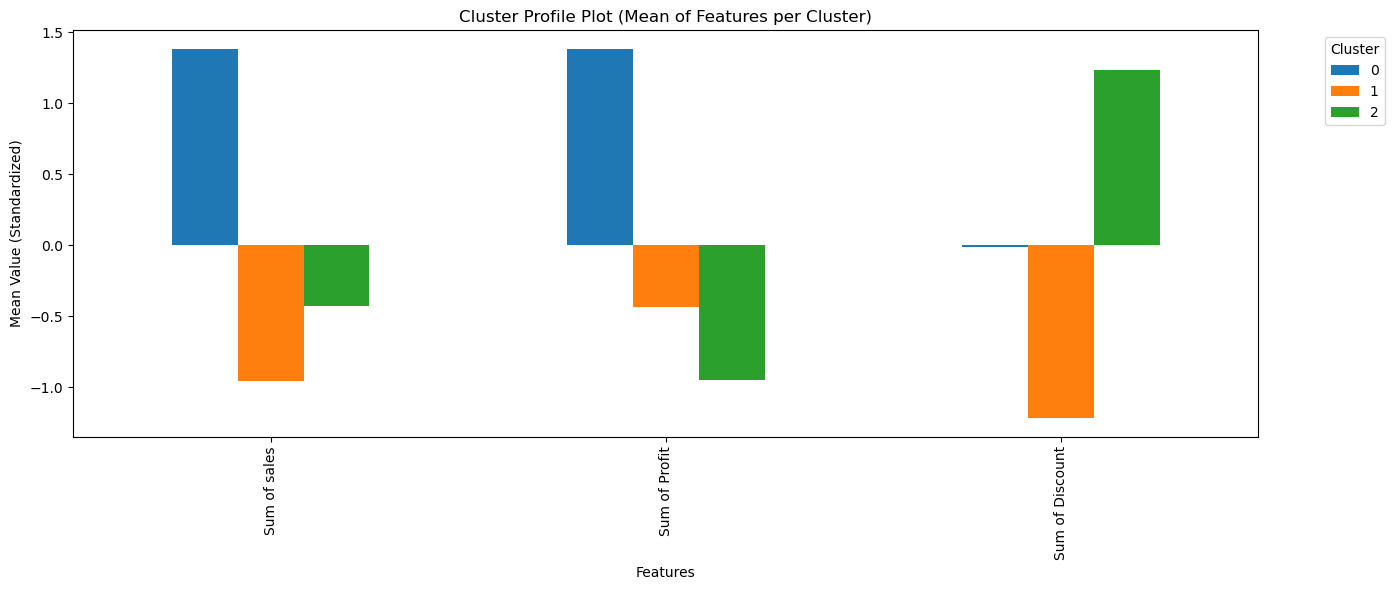

In [156]:
# Calculating the average of every feature
cluster_profile = full_df.drop(['Row Labels'],axis=1)
cluster_profile = cluster_profile.groupby("Cluster").mean()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cluster_profile)
df_2d_with_columns = pd.DataFrame(X_scaled, columns=["Sum of sales", "Sum of Profit", 'Sum of Discount'])
# Box Profile Plot
plt.figure(figsize=(12, 6))
df_2d_with_columns.T.plot(kind='bar', figsize=(14, 6))
plt.title("Cluster Profile Plot (Mean of Features per Cluster)")
plt.ylabel("Mean Value (Standardized)")
plt.xlabel("Features")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [157]:
# Evaluation metrics

dfx = full_df[FEATURES].astype(float).values
scaler = StandardScaler()
Xs = scaler.fit_transform(dfx)
sil_score = silhouette_score(Xs, full_labels)
db_index = davies_bouldin_score(Xs, full_labels)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Davies–Bouldin Index: {db_index:.3f}")

Silhouette Score: 0.743
Davies–Bouldin Index: 0.442


In [148]:
#Save final dataframe to an excel file
OUTPUT_XLSX = "ClusteringState.xlsx"
with pd.ExcelWriter(OUTPUT_XLSX, engine="openpyxl") as writer:
    full_df.to_excel(writer, index=False, sheet_name="Clusters")
print("Saved to", OUTPUT_XLSX)

Saved to ClusteringState.xlsx
